#### Load required modules

In [1]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse
import matplotlib.pyplot as plt

import os.path
from os import path

from pathlib import Path
import dos

sim_folder = 'dos/GSH-WFS_ES'

#### Compute reconstructor from interacion matrix

In [2]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):
    # Open reconstructor pickle data file

    # Load calibration data 
    calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'
    dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM_ES.npz', allow_pickle=True)
    # Compute SH-WFS consolidated interaction matrix
    Dsh = dos.tools.get_SHWFS_D(dt['calibdt'][()]['D'], includeM1S7Rz_col=True)
    M = dos.tools.build_TSVD_RecM(Dsh,  n_r=12)
        
        
    Msimceo = dos.tools.gen_recM_4_SIMCEO(M, dt['calibdt'][()]['wfsMask'])
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(np.eye(Msimceo.shape[0]),sim_folder+'/ReconstructorM', B_or_D='D')
    # dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')
    print('SIMCEO recosntructor matrix dimensions:',Msimceo.shape)

Consolidated WFS-SH Interaction matrix is 7360 x 404
SH-WFS reconstructor matrix pickle file is updated!
SIMCEO recosntructor matrix dimensions: (406, 13824)


In [5]:
dt['calibdt'][()]['De'].shape

(48, 36)

#### Set initial M1/M2 states and generate respective yaml files

In [53]:
# Python code to set simulation states...
from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

# * * * Flag to control if simulation initial state must be updated * * *
updateX0 = False

asec2rad = 4.84814e-6
n_bm = 46
k_states = 1
x0 = np.zeros(42+42+7*n_bm)

if (not path.exists(sim_folder+'/M1.yaml')) or (updateX0):
    # M1 random initial values
    x0_M1_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M1_Tz = k_states*np.hstack([160.0e-6*(2*np.random.rand(6)-1),0]).reshape((7, 1))
    x0_M1_Rxy = k_states*0.38*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M1_Rz = k_states*40*asec2rad*(2*np.random.rand(7,1)-1)
    x0_BM = 0.0*k_states*4e-6*(2*np.random.rand(7,n_bm)-1)

    m1_x0_dt = {
        'mirror' : 'M1',
        'mirror_args': {'mirror_modes': 'bending modes', 
                        'N_MODE': n_bm},
        'state': {'Txyz': np.hstack([x0_M1_Txy, x0_M1_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M1_Rxy, x0_M1_Rz]).tolist(),
                  'modes': x0_BM.tolist() }
    }
    # Dump M1 inital state
    with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
else:
    with open(Path(sim_folder)/'M1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)

if (not path.exists(sim_folder+'/M2.yaml')) or (updateX0):        
    # M2 random initial values
    x0_M2_Txy = k_states*75.0e-6*(2*np.random.rand(7,2)-1)
    x0_M2_Tz = k_states*170.0e-6*(2*np.random.rand(7,1)-1)
    x0_M2_Rxy = k_states*3.0*asec2rad*(2*np.random.rand(7,2)-1)
    x0_M2_Rz = k_states*330*asec2rad*(2*np.random.rand(7,1)-1)

    m2_x0_dt = {
        'mirror' : 'M2',
        'mirror_args': {},
        'state': {'Txyz': np.hstack([x0_M2_Txy, x0_M2_Tz]).tolist(),
                  'Rxyz': np.hstack([x0_M2_Rxy, x0_M2_Rz]).tolist()}
    }
    # Dump M2 inital state
    with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)
else:
    with open(Path(sim_folder)/'M2.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)

#### Instantiate DOS

In [59]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/GSH-WFS_ES/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: M1_ES
INFO:M1_ES:No inputs!
INFO:M1_ES:New output: deltas
INFO:M1_ES:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Rxy

SIMCEO server received: Acknowledging connection from SIMCEO client!


In [60]:
# Start simulation
sim.start()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:M1_ES:EdgeSensors
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:M1_ES:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:M1_ES:EdgeSensors deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 29.434006929397583


In [ ]:
sim.push()

In [ ]:
sim.init()

In [ ]:
sim.terminate()

In [25]:
sim.logs.entries.keys(), sim.logs

(dict_keys(['wfs48', 'M1_ES', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 15 entries:
  * wfs48
    1. data: (13824,)x4
    2. M12_RBM: (406,)x4
  * M1_ES
    1. deltas: (48,)x4
  * ReconstructorM
    1. x_hat: (406,)x4
  * AcO_controller
    1. M1 Txyz: (7, 3)x4
    2. M1 Rxyz: (7, 3)x4
    3. M2 Txyz: (7, 3)x4
    4. M2 Rxyz: (7, 3)x4
    5. M1 BM: (7, 46)x4
  * science
    1. wfe_rms: (1,)x4
    2. segment_wfe_rms: (7,)x4
    3. PSSn: (1,)x4
    4. tiptilt: (2,)x4
    5. segment_piston: (7,)x4
    6. segment_tiptilt: (14,)x4)

In [50]:
sh[1][0,:].dot(Msimceo.T).shape

(406,)

### Simulation results

#### Standalone reconstructor

Final values:
 WFE: [425.44090206] 
 [27.18063108 43.48162008  7.02757452 47.10883417 42.66099296 43.51002048
 85.02773596] 
PSSn: [0.9997574] 
sum of abs seg piston: 2.2617285182491287 
 [-0.11481647 -0.02705098 -0.37180806  0.76323306 -0.11127118  0.74556516
 -0.12798361]


Text(0, 0.5, 'Seg TT')

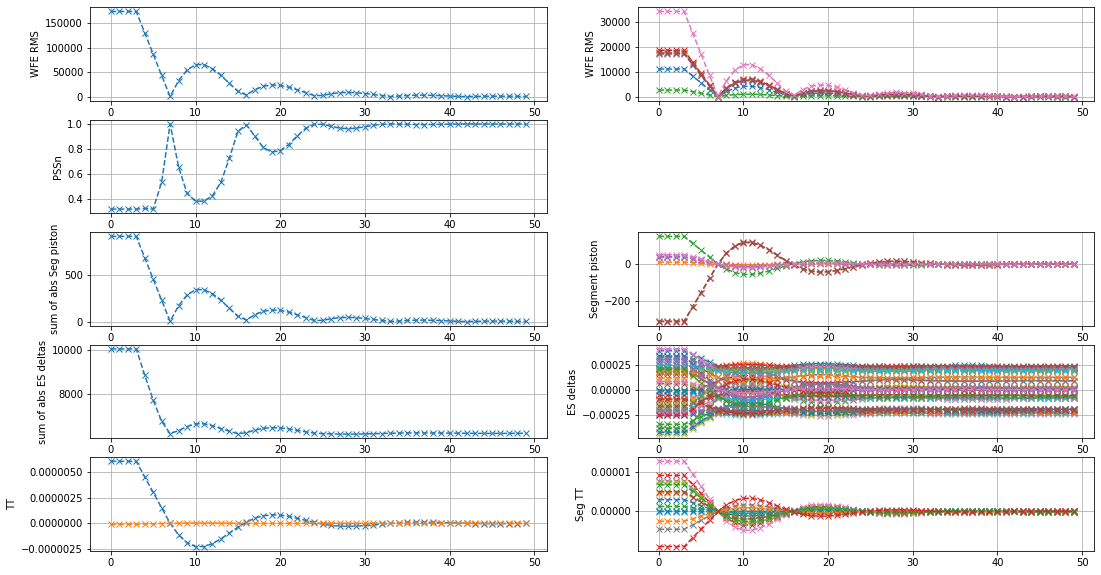

In [22]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 

#### Embed reconstructor (with delay: standalone as identity)

Final values:
 WFE: [425.42498591] 
 [27.18063818 43.48161653  7.02755854 47.10879864 42.6609823  43.510056
 85.02772886] 
PSSn: [0.99975732] 
sum of abs seg piston: 2.2616935790864545 
 [-0.1148279  -0.02705877 -0.37182994  0.76320055 -0.1112939   0.74549177
 -0.12799075]


Text(0, 0.5, 'Seg TT')

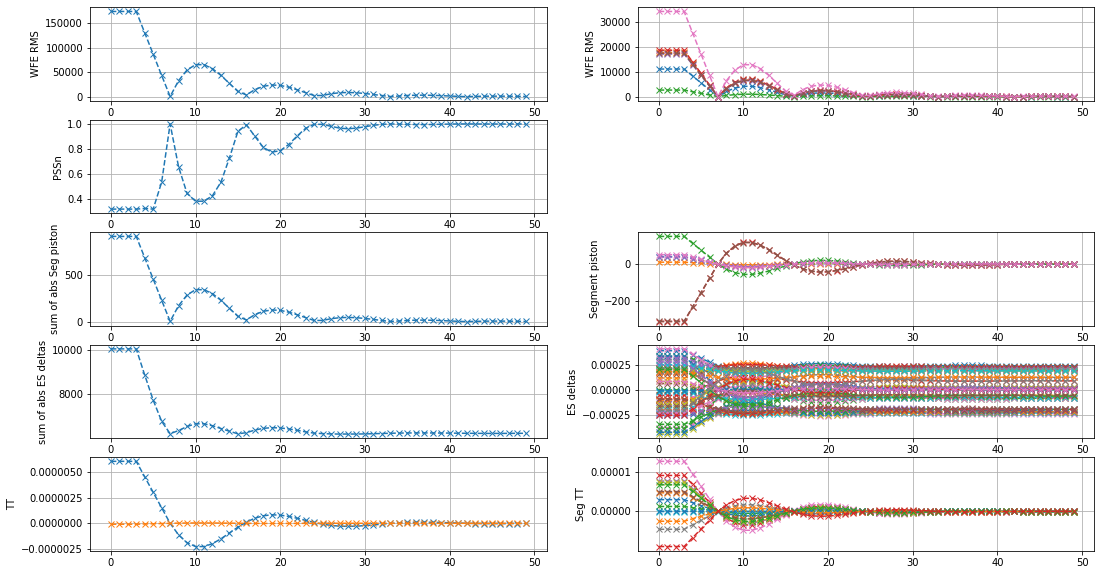

In [61]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 

#### Embed reconstructor (without delay)

Final values:
 WFE: [10.25288299] 
 [0.80005208 0.85869512 0.77179818 0.68199862 0.75642365 0.73762213
 0.2467421 ] 
PSSn: [0.99989483] 
sum of abs seg piston: 0.05548414339084928 
 [-0.00510776 -0.00115398  0.0061047  -0.00143572 -0.0145608  -0.0264928
 -0.00062838]


Text(0, 0.5, 'Seg TT')

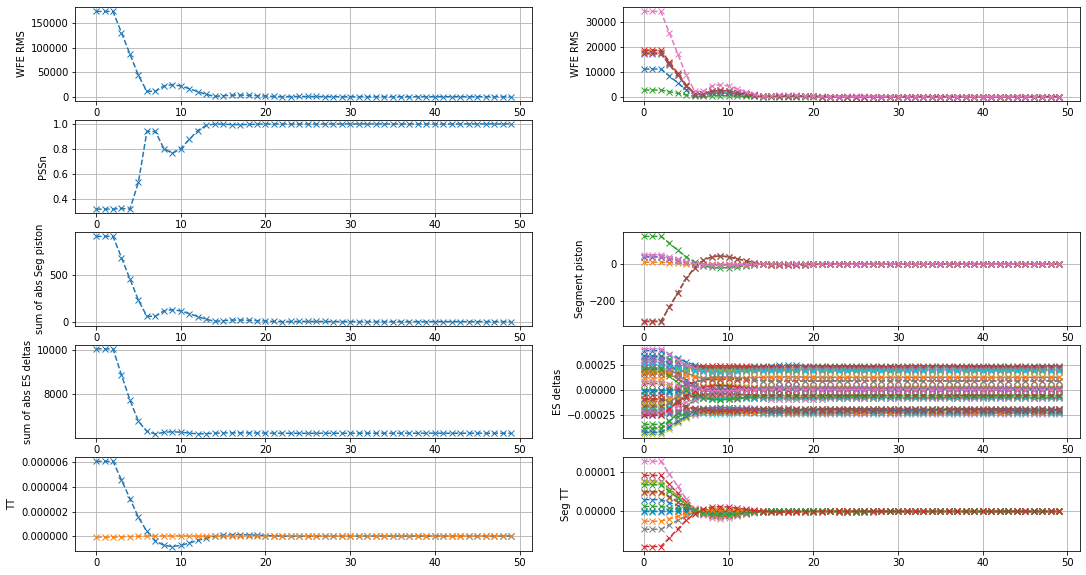

In [68]:
wfe_rms = sim.logs.entries['science']['wfe_rms'].timeSeries
seg_wfe_rms = sim.logs.entries['science']['segment_wfe_rms'].timeSeries
segpiston = sim.logs.entries['science']['segment_piston'].timeSeries
tt = sim.logs.entries['science']['tiptilt'].timeSeries
segtt = sim.logs.entries['science']['segment_tiptilt'].timeSeries
pssn = sim.logs.entries['science']['PSSn'].timeSeries
ESdeltas = sim.logs.entries['M1_ES']['deltas'].timeSeries

print('Final values:\n WFE:',wfe_rms[1][-1]*1.0e9,
      '\n', seg_wfe_rms[1][-1,:]*1.0e9,
      '\nPSSn:',pssn[1][-1], 
      '\nsum of abs seg piston:',np.sum(np.abs(segpiston[1][-1]))*1.0e6,
      '\n', segpiston[1][-1,:]*1.0e6)

plt.figure(figsize=(18,10))
plt.subplot(521)
plt.plot(wfe_rms[0],wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(522)
plt.plot(wfe_rms[0],seg_wfe_rms[1]*1.0e9,'x--')
plt.grid(True)
plt.ylabel('WFE RMS')

plt.subplot(523)
plt.plot(pssn[0],pssn[1],'x--')
plt.grid(True)
plt.ylabel('PSSn')

plt.subplot(525)
plt.plot(segpiston[0],np.sum(np.abs(segpiston[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs Seg piston')

plt.subplot(526)
plt.plot(segpiston[0],segpiston[1]*1.0e6,'x--')
plt.grid(True)
plt.ylabel('Segment piston') 

plt.subplot(527)
plt.plot(segpiston[0],np.sum(np.abs(ESdeltas[1]),axis=1)*1.0e6,'x--')
plt.grid(True)
plt.ylabel('sum of abs ES deltas') 

plt.subplot(528)
plt.plot(segpiston[0],ESdeltas[1],'x--')
plt.grid(True)
plt.ylabel('ES deltas') 

plt.subplot(529)
plt.plot(tt[0],tt[1],'x--')
plt.grid(True)
plt.ylabel('TT') 

plt.subplot(5,2,10)
plt.plot(segtt[0],segtt[1],'x--')
plt.grid(True)
plt.ylabel('Seg TT') 